In [1]:
import numpy as np
import pandas as pd

import datetime

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

Notebook last run (end-to-end): 2025-01-31 04:54:48.923183


In [2]:
df = pd.read_csv("../data/high_diamond_ranked_10min.csv")
# From exploratory data analysis notebook
drop_columns = ['gameId', 'blueEliteMonsters', 'redEliteMonsters', 'redGoldDiff', 'redGoldDiff', 'redExperienceDiff', 'redFirstBlood', 'redDeaths', 'blueDeaths']
df = df.drop(columns=drop_columns)
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,...,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,11,0,0,0,17210,...,0,0,0,16567,6.8,17047,197,55,19.7,1656.7
1,0,12,1,0,5,5,0,0,0,14712,...,1,1,1,17620,6.8,17438,240,52,24.0,1762.0
2,0,15,0,0,7,4,1,0,0,16113,...,0,0,0,17285,6.8,17254,203,28,20.3,1728.5
3,0,43,1,0,4,5,0,1,0,15157,...,0,0,0,16478,7.0,17961,235,47,23.5,1647.8
4,0,75,4,0,6,6,0,0,0,16400,...,1,0,0,17404,7.0,18313,225,67,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,5,1,0,0,17765,...,0,0,0,15246,6.8,16498,229,34,22.9,1524.6
9875,1,54,0,0,6,8,1,0,0,16238,...,0,0,0,15456,7.0,18367,206,56,20.6,1545.6
9876,0,23,1,0,6,5,0,0,0,15903,...,1,0,0,18319,7.4,19909,261,60,26.1,1831.9
9877,0,14,4,1,2,3,1,0,0,14459,...,0,0,0,15298,7.2,18314,247,40,24.7,1529.8


## Train-Test Split

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df['blueWins']
X = df.drop(columns=['blueWins'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaler = StandardScaler().fit(X_train)

X_train_scaled = X_train_scaler.transform(X_train)

In [4]:
# perform principal component analysis
from sklearn.decomposition import PCA

# find the number of components that explain 95% of the variance
pca = PCA(n_components=0.95)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

X_test_scaled = X_train_scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of components: {pca.n_components_}")

Number of components: 17


In [5]:
from dataclasses import dataclass, field
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

@dataclass
class ModelData:
    model: object
    accuracies: list = field(default_factory=lambda: [])
    max_accuracy: float = -float('inf')
    number_of_PCs: int = None

models = {
    "Logistic Regression": ModelData(LogisticRegression()),
    "LDA": ModelData(LinearDiscriminantAnalysis()),
    "KNN": ModelData(KNeighborsClassifier()),
    "SVM": ModelData(SVC()),
    "Random Forest": ModelData(RandomForestClassifier())
    # We want to tweak a hyperparameter for QDA, so we'll do that separately
}

for name, model_data in models.items():
    print(f"Now training {name} model...", end=" ")
    start_time = datetime.datetime.now()
    for i in range(1, pca.n_components_ + 1):
        model_data.model.fit(X_train_pca[:, :i+1], y_train)
        score = model_data.model.score(pca.transform(X_test_scaled)[:, :i+1], y_test)
        model_data.accuracies.append(score)
        if score > model_data.max_accuracy:
            model_data.max_accuracy = score
            model_data.number_of_PCs = i
    print(f"done ({datetime.datetime.now() - start_time}) and max accuracy of {model_data.max_accuracy:.3f} achieved with {model_data.number_of_PCs} PCs")

Now training Logistic Regression model... done (0:00:00.175919) and max accuracy of 0.736 achieved with 4 PCs
Now training LDA model... done (0:00:00.170011) and max accuracy of 0.736 achieved with 4 PCs
Now training KNN model... done (0:00:02.411852) and max accuracy of 0.696 achieved with 6 PCs
Now training SVM model... done (0:00:33.457142) and max accuracy of 0.728 achieved with 4 PCs
Now training Random Forest model... done (0:00:47.250527) and max accuracy of 0.726 achieved with 16 PCs


In [13]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Changing regularization parameter helped improve the accuracy of the model before PCA, maybe it will after PCA as well
x = np.arange(1, pca.n_components_ + 1)
y = np.arange(0, 1, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.zeros((10, pca.n_components_))

QDA_max_accuracy = 0
QDA_max_accuracy_params = (0, 0)

for i in range(1, pca.n_components_ + 1):
    for j in range(0, 10):
        qda = QuadraticDiscriminantAnalysis(reg_param=j/10)
        qda.fit(X_train_pca[:, :i+1], y_train)
        qda_accuracy = accuracy_score(y_test, qda.predict(X_test_pca[:, :i+1]))
        Z[j, i - 1] = qda_accuracy
        if qda_accuracy > QDA_max_accuracy:
            QDA_max_accuracy = qda_accuracy
            QDA_max_accuracy_params = (i, j/10)

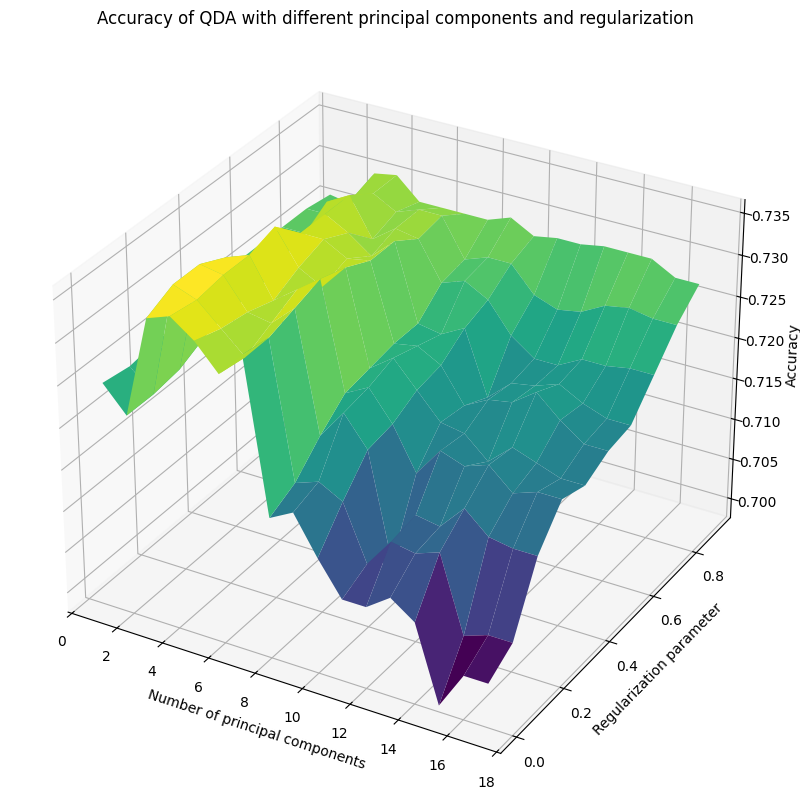

In [14]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(10, 10)

ax.set_title("Accuracy of QDA with different principal components and regularization")
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Regularization parameter")
ax.set_zlabel("Accuracy")
# zorder isn't working for some reason
# ax.scatter(max_accuracy_params[0], max_accuracy_params[1], max_accuracy, 'b.', s=5000, color='r', zorder=2.5)
ax.plot_surface(X, Y, Z, cmap='viridis', zorder=1)
plt.show()

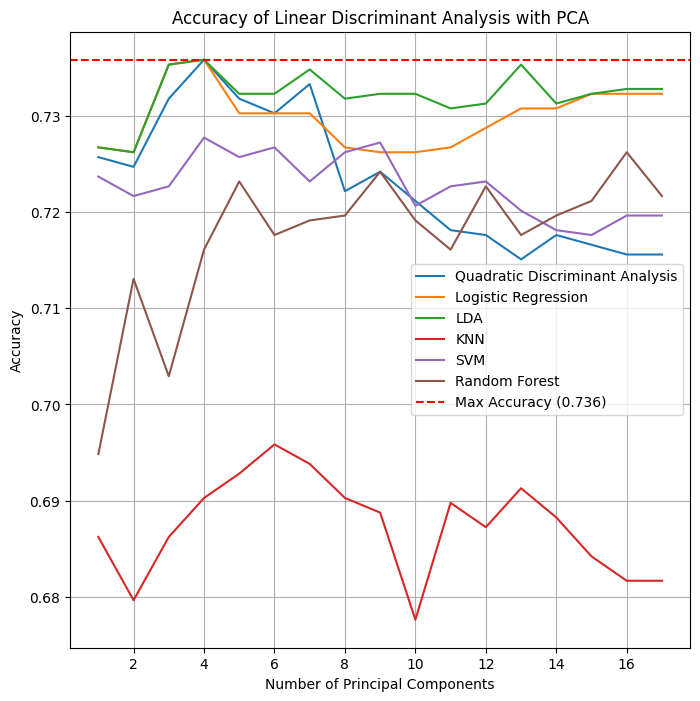

In [15]:
fig = plt.figure()
fig.set_size_inches(8, 8)

plt.plot(range(1, pca.n_components_+1), Z[QDA_max_accuracy_params[0]], label="Quadratic Discriminant Analysis")
for name, model_data in models.items():
    plt.plot(range(1, pca.n_components_+1), model_data.accuracies, label=name)
plt.grid()
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.title("Accuracy of Linear Discriminant Analysis with PCA")

# plot horizontal line for max accuracy
max_accuracy = max([model_data.max_accuracy for model_data in models.values()] + [QDA_max_accuracy])
plt.axhline(max_accuracy, color='r', linestyle='--', label=f"Max Accuracy ({max_accuracy:.3f})")
plt.legend()
plt.show()

In [41]:
# Neural network on 5 principal components
import tensorflow as tf

model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

epochs = 100

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history_1 = model_1.fit(X_train_pca[:, :6], y_train, epochs=epochs, verbose=1)
loss, accuracy = model_1.evaluate(X_test_pca[:, :6], y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6707 - loss: 0.5923
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7299 - loss: 0.5402
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7324 - loss: 0.5315
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7224 - loss: 0.5388
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7235 - loss: 0.5372
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7406 - loss: 0.5186
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7276 - loss: 0.5302
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7350 - loss: 0.5260
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7269 - loss: 0.5310
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7346 - loss: 0.5276
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7354 - loss: 0.5267
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━━━━━

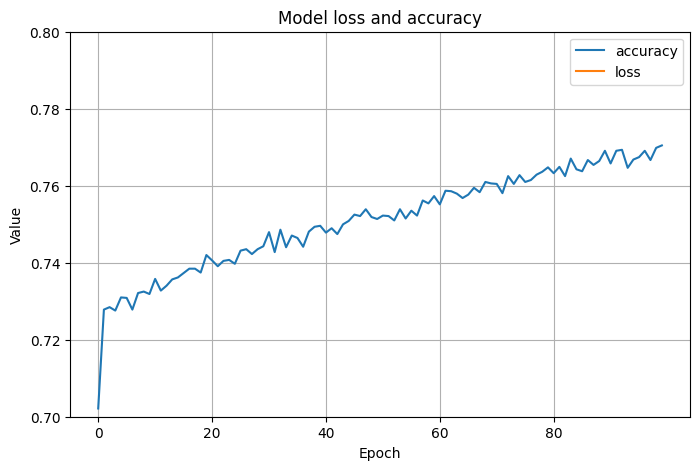

In [42]:
pd.DataFrame(history_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.7, 0.8)
plt.title("Model loss and accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, epochs, 20))
plt.show()

In [43]:
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# triple epochs
epochs = 300

# double learning rate
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history_2 = model_2.fit(X_train_pca[:, :6], y_train, epochs=epochs, verbose=1)
loss, accuracy = model_2.evaluate(X_test_pca[:, :6], y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6934 - loss: 0.5726
Epoch 2/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7138 - loss: 0.5539
Epoch 3/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7246 - loss: 0.5357
Epoch 4/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7268 - loss: 0.5398
Epoch 5/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7261 - loss: 0.5357
Epoch 6/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7171 - loss: 0.5424
Epoch 7/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7355 - loss: 0.5232
Epoch 8/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7398 - loss: 0.5185
Epoch 9/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7214 - loss: 0.5357
Epoch 10/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7339 - loss: 0.5327
Epoch 11/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7299 - loss: 0.5331
Epoch 12/300
247/247 ━━━━━━━━━━━━━━━━━━━━

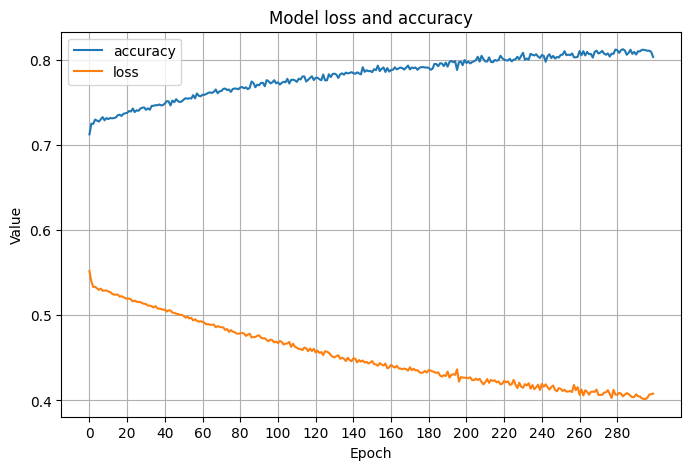

In [44]:
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model loss and accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, epochs, 20))
plt.show()

In [45]:
# make the model deeper
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

epochs = 300

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history_3 = model_3.fit(X_train_pca[:, :6], y_train, epochs=epochs, verbose=1)
loss, accuracy = model_3.evaluate(X_test_pca[:, :6], y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6633 - loss: 0.6094
Epoch 2/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7183 - loss: 0.5448
Epoch 3/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7212 - loss: 0.5407
Epoch 4/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7370 - loss: 0.5297
Epoch 5/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7330 - loss: 0.5358
Epoch 6/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7229 - loss: 0.5419
Epoch 7/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7328 - loss: 0.5283
Epoch 8/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7286 - loss: 0.5375
Epoch 9/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7271 - loss: 0.5388
Epoch 10/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7421 - loss: 0.5210
Epoch 11/300
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7457 - loss: 0.5217
Epoch 12/300
247/247 ━━━━━━━━━━━━━━━━━━━━

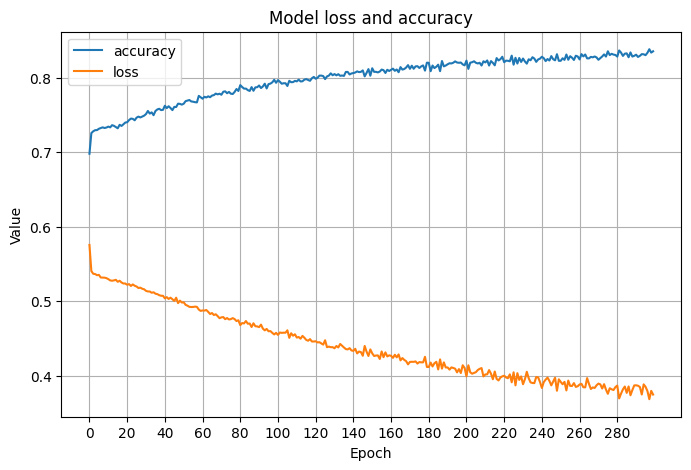

In [48]:
# still can't get back above 71% accuracy!
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model loss and accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, epochs, 20))
plt.show()

In [49]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-01-31 05:51:12.173165 (duration: 0:56:23.249982)
